<a href="https://colab.research.google.com/github/sm354/COL870-Assignment-1/blob/main/2_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
import io

if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  

# device = "cpu"

pretrained = "random" # glove or random
# char_embeds = "Yes"

'''Helper Functions'''
# reading text file in python and making list of sentences (list of lists) and list of tags(list of lists)
def load_data(datapath, buildvocab_tags= True, vocab = None, nertags = None):
    if(buildvocab_tags == True):
        all_words = []
        all_tags = []
        with open(datapath) as f:
            lines = f.readlines()
            sent_num = 0
            for line in lines[1:]: #1: so that the first blank line isn't taken into account
                if(line == "\n"):
                    sent_num+=1
                else:
                    line_sep = line.split(sep = " ")
                    all_words.append(line_sep[0])
                    all_tags.append(line_sep[3][:-1])
                    
        words = list(set(all_words))
        tags = list(set(all_tags))

        vocab = {}
        vocab['<pad>'] = 0 # for padding input sequences
        vocab['<oov>'] = 1
        for i, word in enumerate(words):
            vocab[word] = i+2
            
        nertags = {}
        nertags['padtag'] = 0
        for i,nertag in enumerate(tags):
            nertags[nertag] = i+1

    train_sent = []
    train_tags = []
    with open(datapath) as f:
        lines = f.readlines()
        sent_num = 0
        sentence = []
        tag = []
        for line in lines[1:]: #1: so that the first blank line isn't taken into account
            if(line == "\n"):
                sent_num+=1
                train_sent.append(sentence)
                train_tags.append(tag)
                sentence = []
                tag = []
            else:
                line_sep = line.split(sep = " ")
                if(line_sep[0] in vocab.keys()):
                    sentence.append(vocab[line_sep[0]])
                else:
                    sentence.append(vocab['<oov>'])
                    
                tag.append(nertags[line_sep[3][:-1]])

    # padding the sentences at the end
    seq_maxlen = max(len(x) for x in train_sent)
    x_lengths = [len(x) for x in train_sent]
    Xtrain = []
    Ytrain = []
    for sent, tags in zip(train_sent, train_tags):
        length_toappend = seq_maxlen - len(sent)
        Xtrain.append(sent+[0]*length_toappend)
        Ytrain.append(tags+[0]*length_toappend)


    Xtrain = torch.Tensor(Xtrain)
    Ytrain = torch.Tensor(Ytrain)
    x_lengths = torch.Tensor(x_lengths)
    # print(Xtrain.shape, Ytrain.shape, x_lengths.shape)
    
    return Xtrain, Ytrain, x_lengths, vocab, nertags

def load_char_data(words, charvocab):
    train_char_sent = []
    train_char_label = []
    for word in words:
        chars = []
        char_labels = []

        word_sep = list(word)
        for c in word_sep[:-1]:
            if (c in charvocab.keys()):
                chars.append(charvocab[c])
            else:
                chars.append(charvocab['<oovchar>'])
        for c in word_sep[1:]:
            if (c in charvocab.keys()):
                char_labels.append(charvocab[c])
            else:
                char_labels.append(charvocab['<oovchar>'])
        
        train_char_sent.append(chars)
        train_char_label.append(char_labels)

    # padding the char_sents at the end
    seq_maxlen = max(len(x) for x in train_char_sent)
    x_lengths_char = [len(x) for x in train_char_sent]
    Xtrain_char = []
    Ytrain_char = []
    for char_sent, char_label in zip(train_char_sent, train_char_label):
        length_toappend = seq_maxlen - len(char_sent)
        Xtrain_char.append(char_sent+[0]*length_toappend)
        Ytrain_char.append(char_label+[0]*length_toappend) # 0 is padchar


    Xtrain_char = torch.Tensor(Xtrain_char)
    Ytrain_char = torch.Tensor(Ytrain_char)
    x_lengths_char = torch.Tensor(x_lengths_char)
    # print(Xtrain.shape, Ytrain.shape, x_lengths.shape)
    
    return Xtrain_char, Ytrain_char, x_lengths_char

def pad_chars(topadlist, maxlen):
    topadlist = topadlist + [0]*(maxlen-len(topadlist))

    return topadlist

def make_id2word_charvocab(vocab, charvocab):
    max_charlen = max(len(word) for word in vocab.keys())
    print(max_charlen)
    word_charlevel_vocab = {}
    wordid2wordlen = {}
    for word in vocab.keys():
        word_charlevel_vocab[vocab[word]] = [charvocab[w] if w in charvocab.keys() else charvocab['<oovchar>'] for w in word]
        word_charlevel_vocab[vocab[word]] = pad_chars(word_charlevel_vocab[vocab[word]], max_charlen)

        wordid2wordlen[vocab[word]] = len(word)
        # word_charlevel_vocab[vocab[word]] = word_charlevel_vocab[vocab[word]].extend([charvocab['<padchar>']]*(max_charlen-len(word_charlevel_vocab[vocab[word]])))
    return word_charlevel_vocab, wordid2wordlen


def load_char_level(X, wordid2word_charlevel_vocab, wordid2wordlen):
    #X is of shape (no.of.sentences, 104)
    Xcharlevel = [] # will finally be fo shape (total.sentences, max_sent.len, )
    Xcharlevel_lengths = []
    for i in range(X.shape[0]):
        sentence = []
        wordlengths = []
        for j in range(X.shape[1]):
            sentence.append(torch.tensor([wordid2word_charlevel_vocab[int(X[i, j].item())]]))
            wordlengths.append(wordid2wordlen[int(X[i, j].item())])
            # sentences = pad_sequence(sentences)
        # print(i)
        Xcharlevel_lengths.append(wordlengths)
        Xcharlevel.append(torch.stack(sentence))
    
    return torch.squeeze(torch.stack(Xcharlevel)), torch.tensor(Xcharlevel_lengths)

def get_charvocab(vocab):
    # using vocab make charvocab
    words = list(vocab.keys())
    characters = [char for word in words for char in word]
    characters = list(set(characters))
    char_vocab = {}
    char_vocab["<padchar>"] = 0
    char_vocab["<oovchar>"] = 1
    for i, char in enumerate(characters):
        char_vocab[char] = i+2

    return char_vocab

### Training Data
### using dataloader to make data batches

In [3]:
traindatapath = "/content/drive/MyDrive/Q2_DL/train.txt"
devdatapath = "/content/drive/MyDrive/Q2_DL/dev.txt"

Xtrain, Ytrain, x_trainlengths, vocab, nertags = load_data(traindatapath, buildvocab_tags=True)
Xdev, Ydev, x_devlengths, _, _ = load_data(devdatapath, buildvocab_tags=False, vocab = vocab, nertags = nertags)


In [4]:
# Character Level training data making
# make vocabulary of characters from train vocabulary
char_vocab = get_charvocab(vocab)
wordid2word_charlevel_vocab, wordid2wordlen = make_id2word_charvocab(vocab, char_vocab) # of the form {word:[1,2,3,4]}, {wordnum:wordlen}
#make char level train data for the char embeddings 
Xtrain_char, xlength_char = load_char_level(Xtrain, wordid2word_charlevel_vocab, wordid2wordlen)
#finally make the dataloader for train
traindataset = TensorDataset(Xtrain, Xtrain_char, Ytrain, x_trainlengths, xlength_char)
Trainloader = DataLoader(traindataset, batch_size= 128, shuffle=True)


# Character Level validation data making
Xdev_temp, Ydev_temp, x_devlengths_temp, devvocab, devnertags = load_data(devdatapath, buildvocab_tags=True)
wordid2word_charlevel_vocab_dev, wordid2wordlen_dev = make_id2word_charvocab(devvocab, char_vocab) # of the form {word:[1,2,3,4]}, {wordnum:wordlen}
#make char level train data for the char embeddings 
Xdev_char, xdevlength_char = load_char_level(Xdev_temp, wordid2word_charlevel_vocab_dev, wordid2wordlen_dev)
#finally make the dataloader for train
devdataset = TensorDataset(Xdev, Xdev_char, Ydev, x_devlengths, xdevlength_char)
Devloader = DataLoader(traindataset, batch_size= 128, shuffle=True)

64
26


In [6]:
embedding_size = 100
if(pretrained == "glove"):
    gloveembeddings_index = {}
    with io.open("/content/drive/MyDrive/Q2_DL/glove.6B.100d.txt", encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:],dtype='float32')
            gloveembeddings_index[word] = coefs

    #using vocab and Xtrain, Xvalid, get pretrained glove word embeddings
    glove_embeds = np.zeros((len(vocab), embedding_size))
    for word in vocab.keys():
        if(word in gloveembeddings_index.keys()):
            # for the pad word let theembedding be all zeros
            glove_embeds[vocab[word]] = gloveembeddings_index[word]
        else:
            glove_embeds[vocab[word]] = np.random.randn(embedding_size)
    word_embeds = torch.Tensor(glove_embeds)
    # print(glove_embeds.shape) # shape (vocablength , embedding dim)

if(pretrained == "random"):
    num_words = len(vocab)
    word_embeds = torch.rand(num_words, embedding_size)

# hence we get word_embeds which we could use afterwards


In [7]:
#weight matrix for cross entropy loss
weight = torch.zeros([len(nertags)])
for i in range(len(nertags)):
    weight[i] = 1/((Ytrain.view(-1) == i).sum())
# print(weight)

In [8]:
char_onehot = torch.eye(len(char_vocab))
# print(char_onehot.type())

# LSTM models for character **level**

In [9]:
class forLSTM(nn.Module):
    def __init__(self, embedding_size, hidden_size, pretr_char_embed):
        super(forLSTM, self).__init__()
        self.charembed = nn.Embedding.from_pretrained(pretr_char_embed, freeze = True) #size of pretrained = (totalchars,embedding size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, bidirectional = True, batch_first = True)

    def forward(self, xchar, xlength_char):
        #xchar is of shape(batchsize, seqlen_maxinbatch, maxwordlen-ie max char = 6)

        shape = xchar.shape
        xchar = xchar.view(-1, shape[2])
        xlength_char = xlength_char.view(-1)
        input = pack_padded_sequence(xchar, xlength_char.cpu(), batch_first=True, enforce_sorted=False)
        input, _ = pad_packed_sequence(input, batch_first=True)
        embed = self.charembed(input)
        _, (h,_) = self.lstm(embed) #h is of size (2, 128*maxno. of words in a sentence in the batch, 25)
        h = h.view(h.shape[1], 50)
        h = h.view(shape[0], shape[1], 50)
        return h

        # out = []
        # for i in range(xchar.shape[1]):
        #     input = pack_padded_sequence(xchar[:, i, :], xlength_char[:, i].cpu(), batch_first=True, enforce_sorted=False)
        #     input, _ = pad_packed_sequence(input, batch_first=True)
        #     embed = self.charembed(input)
        #     _, (h,_) = self.lstm(embed)
        #     out.append(h) #h is of shape [1, 128, 25]
        # out = torch.stack(out) # out(lhs) is of size [104, 1, 128, 25]
        # out = out.squeeze().permute(1, 0, 2)
        # return out
        #(batchsize, seqlen, embeddingsize = 25)


# class backLSTM(nn.Module):
#     def __init__(self, embedding_size, hidden_size, pretr_char_embed):
#         super(backLSTM, self).__init__()
#         self.charembed = nn.Embedding.from_pretrained(pretr_char_embed, freeze = True) #size of pretrained = (totalchars,embedding size)
#         self.lstm = nn.LSTM(embedding_size, hidden_size, dropout = 0.5, bidirectional = False, batch_first = True)

#     def forward(self, xchar, xlength_char):
#         #xchar is of shape(batchsize, seqlen_maxinbatch, maxwordlen-ie max char = 6)
#         out = []
#         for i in range(xchar.shape[1]):
#             input = pack_padded_sequence(xchar[:, i, :], xlength_char[:, i].cpu(), batch_first=True, enforce_sorted=False)
#             input, _ = pad_packed_sequence(input, batch_first=True)
#             #flip and feed the input into the backlstm
#             input = torch.flip(input, [1]) #flip along the dimension of the maxwordlength
#             embed = self.charembed(input)
#             _, (h,_) = self.lstm(embed)
#             out.append(h) #h is of shape [1, 128, 25]
#         out = torch.stack(out) # out(lhs) is of size [104, 1, 128, 25]
#         out = out.squeeze().permute(1, 0, 2)
#         return out
#         #(batchsize, seqlen, embeddingsize = 25)


# BiLSTM Model

In [19]:
class BiLSTM(nn.Module):
    def __init__(self, embedding_size, hidden_size, total_words, num_class, pretrained = False, pretrained_embed = None, char_embed_size = 0, pretr_char_embed = None):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        # self.wordembed = nn.Embedding(total_words, embedding_size) #weights initiallized from std normal dist, randomly
        # if(pretrained == True):
        #     self.wordembed.weight = nn.Parameter(pretrained_embed) #pretrained embeds have size (total_words, embedding_size)

        self.wordembed = nn.Embedding.from_pretrained(pretrained_embed, freeze = True)
        self.for_charembed = forLSTM(embedding_size = char_embed_size, hidden_size = 25, pretr_char_embed = pretr_char_embed)
        # self.back_charembed = backLSTM(embedding_size = char_embed_size, hidden_size = 25, pretr_char_embed = pretr_char_embed)

        self.dropout = nn.Dropout(p = 0.5)
        self.bilstm = nn.LSTM(embedding_size + 50,hidden_size, bidirectional = True, batch_first = True)
        self.linear = nn.Linear(2*hidden_size, num_class) # 2 because forward and backward concatenate

    def forward(self, x, xchar, xlengths, xlength_char):
        x = pack_padded_sequence(x, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        x, _ = pad_packed_sequence(x, batch_first=True)

        xlength_char = pack_padded_sequence(xlength_char, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        xlength_char, _ = pad_packed_sequence(xlength_char, batch_first=True, padding_value = len("<pad>")) 
        # above this line padding value is taken as len of pad word becasue that is what we pad sentences 
        # with hance at a character level it should be the length

        xchar = pack_padded_sequence(xchar, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        xchar, _ = pad_packed_sequence(xchar, batch_first=True)

        word_embedding = self.wordembed(x) # x is of size(batchsize, seq_len), wordembed is of size (batchsize, seq_len, embedding_size = 100)
        forwardchar= self.for_charembed(xchar, xlength_char) #forwardchar and backwardchar would be of size (batchsize, seqlen. embedding_size = 25each) 
        word_embedding = torch.cat((word_embedding, forwardchar), dim = 2)

        # word_embedding = self.dropout(word_embedding) #dropout
        out, (h,c) = self.bilstm(word_embedding) #'out' has dimension(batchsize, seq_len, 2*hidden_size)

        out = self.linear(out) #now 'out' has dimension(batchsize, seq_len, num_class)
        out = out.view(-1, out.shape[2]) # shape (128*seqlen, 18)
        out = F.log_softmax(out, dim=1) # take the softmax across the dimension num_class, 'out' has dimension(batchsize, seq_len, num_class)
        return out
        
        

In [20]:
model = BiLSTM(embedding_size = 100, hidden_size = 100, total_words = len(vocab), num_class = 18, pretrained = True, pretrained_embed = word_embeds, char_embed_size = len(char_vocab), pretr_char_embed = char_onehot).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3) 
lossfunction = nn.CrossEntropyLoss(weight = weight)

# print(model)
def accuracy(y, ypred, nertags):
    y = y.numpy()
    ypred = ypred.numpy()
    mask = (y != nertags['padtag']) * (y != nertags['O'])
    # print(mask.sum())
    # print(mask)
    y = y*mask
    ypred = ypred*mask
    acc = ((y==ypred)*mask).sum()/mask.sum()
    return acc

# def lossfunction(ypred, yactual):
#     mask_padded = (yactual!=nertags['padtag']).float()
#     logprobs = ypred[:, yactual]
#     logprobs = logprobs*mask_padded
#     num = (yactual!=nertags['padtag']).sum().item()
#     return -torch.sum(logprobs)/num

def validate(model, loader):
    with torch.no_grad():
        validloss = 0
        acc = 0
        i = 0
        for step, (X, Xchar, Y, xlen, xlen_char) in enumerate(loader):
            Y = pack_padded_sequence(Y, xlen, batch_first=True, enforce_sorted=False)
            Y, _ = pad_packed_sequence(Y, batch_first=True)
            ypred = model(X.long().to(device), Xchar.to(device), xlen.to(device), xlen_char.to(device))#.permute(0, 2, 1)
            vloss = lossfunction(ypred.to('cpu'), Y.view(-1).type(torch.LongTensor))
            validloss+=vloss
            acc_ = accuracy(Y.view(-1), torch.argmax(ypred.to('cpu'), dim = 1), nertags)
            acc+=acc_
            i+=1

    return validloss/i, acc/i

In [21]:
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.001) 
trainloss = []
validloss = []
acclist = [] #accuracy except pad, O
valacclist = []

In [22]:
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9) 

In [23]:
# Model is ready now we have to train using cross entropy loss
num_epochs = 100
# validloss = []
model.train()
for epoch in range(num_epochs):
    if(epoch == 10):
      model.wordembed.weight.requires_grad = True
    trainacc_interim = []
    for step, (Xbatch , Xchar ,Ybatch, xbatch_len, xlength_char) in enumerate(Trainloader):
        #make gradients 0
        optimizer.zero_grad()
        # print(Xbatch.shape)


        Ybatch = pack_padded_sequence(Ybatch, xbatch_len, batch_first=True, enforce_sorted=False)
        Ybatch, y_lengths = pad_packed_sequence(Ybatch, batch_first=True)
        # print(Ybatch.shape)
        # assert(1==0)

        #get output from model and claculate loss
        ypred = model(Xbatch.long().to(device), Xchar.to(device), xbatch_len.to(device), xlength_char.to(device))#.permute(0, 2, 1)
        if(step%20 == 0):
            # print(ypred.shape, Ybatch.shape)
            acc = accuracy(Ybatch.view(-1), torch.argmax(ypred.to('cpu'), dim = 1), nertags)
            print("train_accuracy = {}".format(acc))
            # trainacc_interim.append(acc)
        
        loss = lossfunction(ypred.to('cpu'), Ybatch.view(-1).type(torch.LongTensor)) #Ybatch has dimension (batchsize, seqlen), ypred has dimension(batchsize, num_classes, seqlen)
        
        #backward and step
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5) # clip gradient to 5
        optimizer.step()
    
    trainloss.append(loss)
    acclist.append(acc)
    # model validation loss and scheduler step for learning rate change if required
    val_loss, val_acc = validate(model, Devloader)
    validloss.append(val_loss)
    valacclist.append(val_acc)
    scheduler.step(val_loss)
    print('\nepoch = {}, training_loss = {}, validation_loss ={}'.format(epoch, trainloss[-1], validloss[-1]))        
        
        
        

train_accuracy = 0.10401891252955082
train_accuracy = 0.0022271714922048997
train_accuracy = 0.1087962962962963
train_accuracy = 0.09417040358744394
train_accuracy = 0.09832134292565947
train_accuracy = 0.06697459584295612
train_accuracy = 0.10436893203883495
train_accuracy = 0.0
train_accuracy = 0.06880733944954129
train_accuracy = 0.12938596491228072
train_accuracy = 0.19554455445544555
train_accuracy = 0.19205298013245034
train_accuracy = 0.20963855421686747
train_accuracy = 0.18850574712643678
train_accuracy = 0.1966019417475728

epoch = 0, training_loss = 2.8286736011505127, validation_loss =2.742567539215088
train_accuracy = 0.07862407862407862
train_accuracy = 0.1630901287553648
train_accuracy = 0.020689655172413793
train_accuracy = 0.13709677419354838
train_accuracy = 0.15676959619952494
train_accuracy = 0.1721132897603486
train_accuracy = 0.18414918414918416
train_accuracy = 0.1497584541062802
train_accuracy = 0.23114355231143552
train_accuracy = 0.21750663129973474
train_accu

In [24]:
print((xlength_char).shape)

torch.Size([86, 104])


In [25]:
print(trainloss)
print(acclist)

[tensor(2.8287, grad_fn=<NllLossBackward>), tensor(2.5109, grad_fn=<NllLossBackward>), tensor(2.2896, grad_fn=<NllLossBackward>), tensor(2.0130, grad_fn=<NllLossBackward>), tensor(1.9253, grad_fn=<NllLossBackward>), tensor(1.7061, grad_fn=<NllLossBackward>), tensor(1.5652, grad_fn=<NllLossBackward>), tensor(1.7114, grad_fn=<NllLossBackward>), tensor(1.3353, grad_fn=<NllLossBackward>), tensor(1.8117, grad_fn=<NllLossBackward>), tensor(1.4661, grad_fn=<NllLossBackward>), tensor(0.8086, grad_fn=<NllLossBackward>), tensor(1.3586, grad_fn=<NllLossBackward>), tensor(1.0047, grad_fn=<NllLossBackward>), tensor(1.1676, grad_fn=<NllLossBackward>), tensor(1.0341, grad_fn=<NllLossBackward>), tensor(0.6837, grad_fn=<NllLossBackward>), tensor(0.6335, grad_fn=<NllLossBackward>), tensor(0.8840, grad_fn=<NllLossBackward>), tensor(0.3562, grad_fn=<NllLossBackward>), tensor(0.3982, grad_fn=<NllLossBackward>), tensor(0.7518, grad_fn=<NllLossBackward>), tensor(0.8395, grad_fn=<NllLossBackward>), tensor(0.5

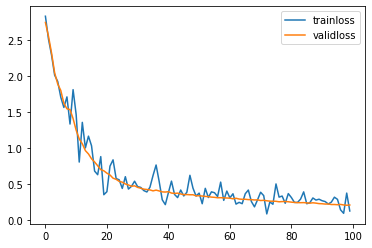

In [26]:
plt.plot(trainloss, label = "trainloss")
plt.plot(validloss, label = "validloss")
plt.legend()
plt.show()

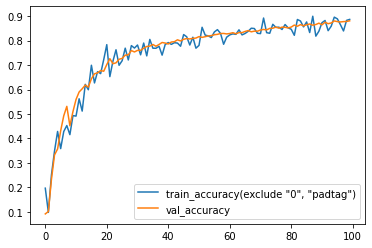

In [27]:
plt.plot(acclist, label = 'train_accuracy(exclude "0", "padtag")')
plt.plot(valacclist, label = 'val_accuracy')
plt.legend()
plt.show()